# 使用信息熵寻找最优划分

![信息熵的目标](../02-Entropy/images/信息熵的目标.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, 2:] # 一共4个特征，我们取地后两个维度的特征
y = iris.target # y分3类

In [3]:
from sklearn.tree import DecisionTreeClassifier 

dt_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=42)
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [4]:
def plot_decision_boundary(model, axis):
    """
    根据模型绘制决策边界
    """
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'


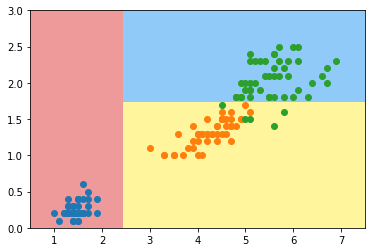

In [5]:
plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])
plt.show()

## 模拟使用信息熵进行划分

In [6]:
def split(X, y, d, value):
    index_a = (X[:, d] <= value)
    index_b = (X[:, d] >  value)
    return X[index_a], X[index_b], y[index_a], y[index_b]

In [7]:
from collections import Counter
from math import log
def entropy(y):
    counter = Counter(y)
    res = 0.0
    for num in counter.values():
        p = num / len(y)
        res += -p * log(p)
    return res

In [8]:
def try_split(X, y):
    best_entropy = float('inf')
    best_d, best_v = -1, -1
    # 穷举搜索
    for d in range(X.shape[1]):
        sorted_index = np.argsort(X[:, d])
        for i in range(1, len(X)):
            a = X[sorted_index[i-1], d]
            b = X[sorted_index[i], d]
            if a != b:
                v = (a + b) / 2
                X_l, X_r, y_l, y_r = split(X, y, d, v)
                e = entropy(y_l) + entropy(y_r)
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v
    return  best_entropy, best_d, best_v

In [9]:
best_entropy, best_d, best_v = try_split(X, y)
print("在第"+str(best_d)+"个维度，阈值为"+str(best_v)+"的地方进行划分，得到的最小信息熵为"+str(best_entropy))

在第0个维度，阈值为2.45的地方进行划分，得到的最小信息熵为0.6931471805599453


In [10]:
X1_l, X1_r, y1_l, y1_r = split(X, y, best_d, best_v)

In [11]:
entropy(y1_l) # 左边已经不需要划分了，信息熵已经到了0，不能再小了

0.0

In [12]:
entropy(y1_r) # 右边还可以继续划分

0.6931471805599453

In [13]:
best_entropy2, best_d2, best_v2 = try_split(X1_r, y1_r)

In [14]:
print("在第"+str(best_d2)+"个维度，阈值为"+str(best_v2)+"的地方进行划分，得到的最小信息熵为"+str(best_entropy2))

在第1个维度，阈值为1.75的地方进行划分，得到的最小信息熵为0.4132278899361904


In [16]:
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_d2, best_v2)

In [17]:
entropy(y2_l)

0.30849545083110386

In [18]:
entropy(y2_r)

0.10473243910508653

> 可以看出上面两个只能都不为0,还可以继续划分，不过两者都比较小了，就算了。一般我们会传max_steps，split次数被max_steps限制